# Display image


*Autor: Milo Charavet*

---



Here I have created the functions used to pass events from .npz files to
images where each PMT is a pixel.

In [1]:
# Import libraries

%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import animation
from tqdm.notebook import tqdm
import math
import h5py
import altair as alt
from pathlib import Path
from math import sqrt

## Convert geometry coordinates to array of IDs

In order to generate an image where each PMT is represented as a pixel, it is necessary to map each coordinate in the space of the PMT to a pixel of the plane.

To do this, the following function is used that receives the .npz geometry file and returns a matrix where each pixel is a pmt of the barrel.

In [4]:
data = np.load('/Users/macbookairdemilo/Desktop/simulations/wcsim_output_example.npz', allow_pickle=True)

In [ ]:
geo = np.load('/content/drive/Shareddrives/HK-Mexico/datos/SK_geo.npz', allow_pickle=True)

In [ ]:
def to_cylindrical(coords):
    x, y, z = coords[0], coords[1], coords[2]
    ro = sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return  ro, theta, z

def unroll_geometry(geo_file):
    
    # PMT positions are passed to cylindrical coordinates.
    cyl_coords = np.array([to_cylindrical(coords) for coords in geo_file['position']])


    pmt_pos = {
        'id': geo_file['tube_no'],
        'theta': cyl_coords[:, 1],
        'z': geo_file['position'][:,2],
    }
    pmt_pos = pd.DataFrame(pmt_pos)
    pmt_pos = pmt_pos.sort_values(by=['z', 'theta'])

    pmt_pos = pmt_pos[abs(pmt_pos['z']) < 1750]

    image = [[ int(pmt_pos.iloc[0]['id']) ]]
    current_row = 0
    last_z = pmt_pos.iloc[0]['z']

    for i in range(1, len(pmt_pos)):
        pmt = pmt_pos.iloc[i]

        if abs(last_z - pmt['z']) > 0.001 :
            image.append([])
            current_row += 1
        last_z = pmt['z']
        image[current_row].append(int(pmt['id']))

    return np.array(image)

## Convert WCSim event to image

Now we will convert the event to image.

In [ ]:
event = {
  'id': data['digi_hit_pmt'][0],
  'charge': data['digi_hit_charge'][0],
  'time': data['digi_hit_time'][0],
}

event = pd.DataFrame(event)

In [ ]:
map = {  }

for i in range(len(mask)):
    for j in range(len(mask[i])):
        pmt_id = mask[i][j]
        map[pmt_id] = (i, j)

In [ ]:
def to_image(event):
    """ Receives event dataframe (id, charge, time) and returns an array of the image."""
  
    event_image = np.zeros(mask.shape + (2,))

    for index, pmt in event.iterrows():
        id = pmt['id']
        charge = pmt['charge']
        time = pmt['time']

    if id in map:
        (i_mask, j_mask) = map[id]
        event_image[i_mask][j_mask] = np.array([charge, time])

    return event_image

In [ ]:
event_image = to_image(event)

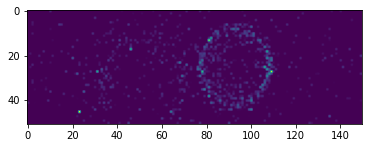

In [ ]:
plt.imshow(event_image[:, :, 0])